In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv


In [2]:
# Import Statements

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.
pd.set_option('display.max_columns', 100)


In [3]:
# Code from https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction 
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# function to calculate evaluation metric
def rmsle(y_true: pd.Series, y_predict: pd.Series) -> float:
    """
    Evaluate root mean squared log error
    :param y_true:
    :param y_predict:
    :return:
    """
    return np.sqrt(msle(y_true, y_predict))

In [4]:
# Import data
INPUT = "../input/ashrae-energy-prediction/"

df_train = pd.read_csv(f"{INPUT}train.csv")
df_test = pd.read_csv(f"{INPUT}test.csv")
bldg_metadata = pd.read_csv(f"{INPUT}building_metadata.csv")
weather_train = pd.read_csv(f"{INPUT}weather_train.csv")
weather_test = pd.read_csv(f"{INPUT}weather_test.csv")
sample = pd.read_csv(f"{INPUT}sample_submission.csv")

In [5]:
df_test = df_test.drop(columns=['row_id'])

In [6]:
df_train = reduce_mem_usage(df=df_train)
df_test = reduce_mem_usage(df=df_test)
weather_train = reduce_mem_usage(df=weather_train)
weather_test = reduce_mem_usage(df=weather_test)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 437.43 Mb (54.2% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [7]:
df_train = df_train.merge(bldg_metadata, on='building_id', how='left')
df_test = df_test.merge(bldg_metadata, on='building_id', how='left')
df_train = df_train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
df_test = df_test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [8]:
import gc
del weather_train, weather_test, bldg_metadata
gc.collect()

0

In [9]:
df_train['timestamp'] = pd.to_datetime(arg=df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(arg=df_test['timestamp'])

## Feature Engineering

In [10]:
# Extracting date features from timestamp
df_train['year'] = df_train['timestamp'].dt.year
df_train['month'] = df_train['timestamp'].dt.month
df_train['day'] = df_train['timestamp'].dt.day
df_train['hour'] = df_train['timestamp'].dt.hour
df_test['year'] = df_test['timestamp'].dt.year
df_test['month'] = df_test['timestamp'].dt.month
df_test['day'] = df_test['timestamp'].dt.day
df_test['hour'] = df_test['timestamp'].dt.hour
df_train['dayofweek'] = df_train['timestamp'].dt.dayofweek
df_test['dayofweek'] = df_test['timestamp'].dt.dayofweek

In [11]:
# Making age feature
df_train['age'] = df_train['year'] - df_train['year_built']
df_test['age'] = df_test['year'] - df_test['year_built']

# Making number of hours passed from start
new_df = df_train.groupby(by=['building_id'], as_index=False)['timestamp'].min()
new_df = new_df.rename(columns = {'timestamp': 'start_ts'})

df_train = df_train.merge(new_df, on = 'building_id', how='left')
df_test = df_test.merge(new_df, on = 'building_id', how='left')

df_train['hours_passed'] = (df_train['timestamp'] - df_train['start_ts']).dt.total_seconds()/3600
df_test['hours_passed'] = (df_test['timestamp'] - df_test['start_ts']).dt.total_seconds()/3600

## Data Cleaning

In [12]:
# site_id =0 has some building where meter readings before May 21, 2016 are not reliable so dropping those records 
df_train = df_train.query('not(site_id==0 & timestamp<"2016-05-21 00:00:00")')

# Missing value handling
cols = ['floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 
        'wind_direction', 'wind_speed']
df_train.loc[:, cols] = df_train.loc[:, cols].interpolate(axis=0)
df_test.loc[:, cols] = df_test.loc[:, cols].interpolate(axis=0)

In [13]:
class NewFeatures:
    """This class constructs features of min, max, median, mean, std_dev based on grouping columns"""
    
    def __init__(self, feature, grouping_cols):
        self.feature = feature
        self.grouping_cols = grouping_cols
        self.features = None
        self.feature_mean = None
        self.feature_median = None
        self.feature_std_dev = None
        self.feature_min = None
        self.feature_max = None
        
    def fetch_values(self, df):
        self.feature_mean = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].mean().rename(columns={self.feature: f'{self.feature}_mean'})
        self.feature_median = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].median().rename(columns={self.feature: f'{self.feature}_median'})
        self.feature_std_dev = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].std().rename(columns={self.feature: f'{self.feature}_std_dev'})
        self.feature_min = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].min().rename(columns={self.feature: f'{self.feature}_min'})
        self.feature_max = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].max().rename(columns={self.feature: f'{self.feature}_max'})
        self.features = self.feature_mean
        self.features[f'{self.feature}_median'] = self.feature_median[f'{self.feature}_median']
        self.features[f'{self.feature}_std_dev'] = self.feature_std_dev[f'{self.feature}_std_dev']
        self.features[f'{self.feature}_min'] = self.feature_min[f'{self.feature}_min']
        self.features[f'{self.feature}_max'] = self.feature_max[f'{self.feature}_max']
    
    def predict(self, df):
        STEP = 10000
        for i in tqdm(range(0, df.shape[0], STEP)):
            df.loc[i:i+STEP-1,:] = df.loc[i:i+STEP-1,:].merge(self.features, on = self.grouping_cols)
        return df

In [14]:
# Convert to categorical datatype
cat_cols = ['meter', 'primary_use', 'site_id', 'building_id', 'year', 'month', 'day', 'hour', 'dayofweek']
for col in cat_cols:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

## Modelling

In [15]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,dayofweek,age,start_ts,hours_passed
103,105,0,2016-01-01,23.303600,1,Education,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0
104,106,0,2016-01-01,0.374600,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0
105,106,3,2016-01-01,0.000000,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0
106,107,0,2016-01-01,175.184006,1,Education,97532,2005.0,10.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,11.0,2016-01-01,0.0
107,108,0,2016-01-01,91.265297,1,Education,81580,1913.0,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,103.0,2016-01-01,0.0


In [16]:
# Make validation set based on time split
df_val = df_train.loc[df_train['timestamp'] >= '2016-11-01 00:00:00']
df_train = df_train.loc[df_train['timestamp'] < '2016-11-01 00:00:00']
y_train = df_train['meter_reading']
y_val = df_val['meter_reading']

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
df_train = df_train.drop(columns=['meter_reading'])
df_val = df_val.drop(columns=['meter_reading'])

# # Create input and target
# y_train = df_train['meter_reading']
# y_train = np.log1p(y_train)
# df_train = df_train.drop(columns=['meter_reading'])

# # Make validation set based on train_test_split
# df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=42)

# Drop timestamp because model does not accept
df_train = df_train.drop(columns=['timestamp', 'start_ts'])
df_val = df_val.drop(columns=['timestamp', 'start_ts'])
df_test = df_test.drop(columns=['timestamp', 'start_ts'])

# Model
lgbmr = LGBMRegressor(random_state=10)
lgbmr.fit(df_train, y_train)
y_predict = lgbmr.predict(df_val)
score = np.sqrt(mse(y_val, y_predict))
# score = rmsle(y_val, y_predict)
print(f"score: {score}")

score: 1.053621230174478


In [17]:
# # Model
model = []
meter_types = list(df_train['meter'].unique().astype('int'))
meter_types.sort()
for meter_type in meter_types:
     print(meter_type)
     model.append(LGBMRegressor(random_state=10))
     X = df_train.loc[df_train['meter']==meter_type, :].reset_index(drop=True)
     y = y_train[df_train['meter']==meter_type].reset_index(drop=True)
     X_validation = df_val.loc[df_val['meter']==meter_type, :].reset_index(drop=True)
     y_validation = y_val[df_val['meter']==meter_type].reset_index(drop=True)
     model[meter_type].fit(X, y)
     y_predict = model[meter_type].predict(X_validation)
     score = np.sqrt(mse(y_validation, y_predict))
     print(f"score: {score}")

0
score: 0.5712098942103687
1
score: 1.4406747374150597
2
score: 1.1925999720943061
3
score: 1.7225343224572198


## Ensemble Modelling

In [18]:
# Half and half learning
X_1st_half = df_train[:int(df_train.shape[0]/2)]
y_1st_half = y_train[:int(df_train.shape[0]/2)]
X_2nd_half = df_train[int(df_train.shape[0]/2):]
y_2nd_half = y_train[int(df_train.shape[0]/2):]

In [19]:
lgbmr_1st_half = LGBMRegressor(random_state=10)
lgbmr_2nd_half = LGBMRegressor(random_state=10)
lgbmr_1st_half.fit(X_1st_half, y_1st_half)
lgbmr_2nd_half.fit(X_2nd_half, y_2nd_half)
y_predict_1 = lgbmr_1st_half.predict(df_val)
y_predict_2 = lgbmr_2nd_half.predict(df_val)
y_predict_1_2 = (pd.Series(data=y_predict_1, name='prediction_1') + pd.Series(data=y_predict_2, name='prediction_2'))/2
score = np.sqrt(mse(y_val, y_predict_1_2))
print(f"score: {score}")

score: 1.107274963569501


In [20]:
# Saving model
filename = 'lgbm_model1.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

filename = 'lgbmr_1st_half.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
lgbmr_1st_half = pickle.load(open(filename, 'rb'))
filename = 'lgbmr_2nd_half.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
lgbmr_2nd_half = pickle.load(open(filename, 'rb'))

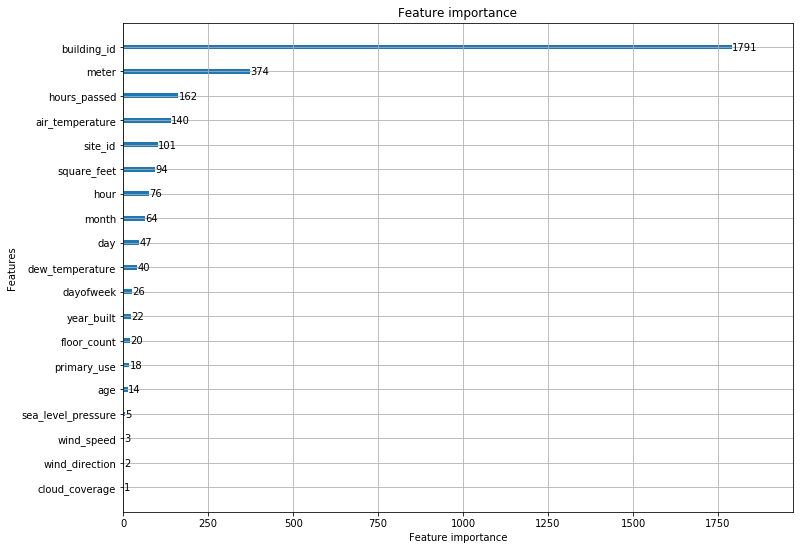

In [21]:
# # Important features
fig, ax = plt.subplots(figsize=(12, 9))
plot_importance(lgbmr, ax=ax)

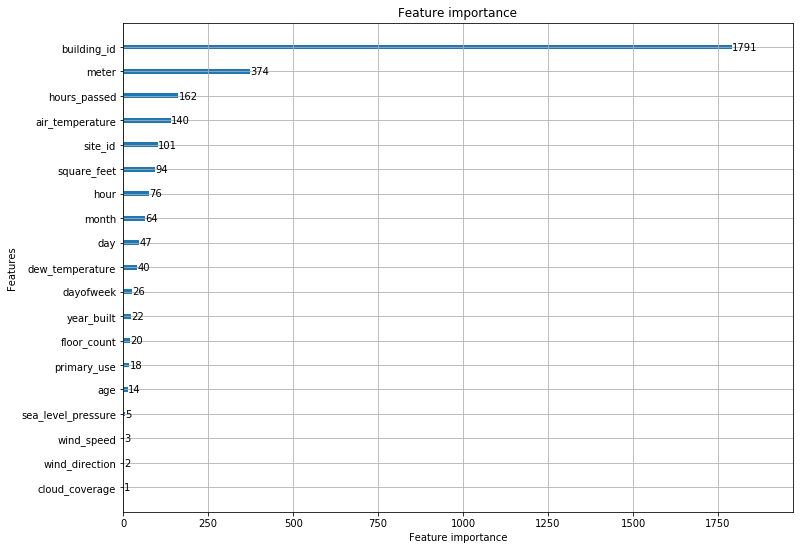

In [22]:
fig, ax = plt.subplots(figsize=(12, 9))
plot_importance(lgbmr_1st_half, ax=ax)

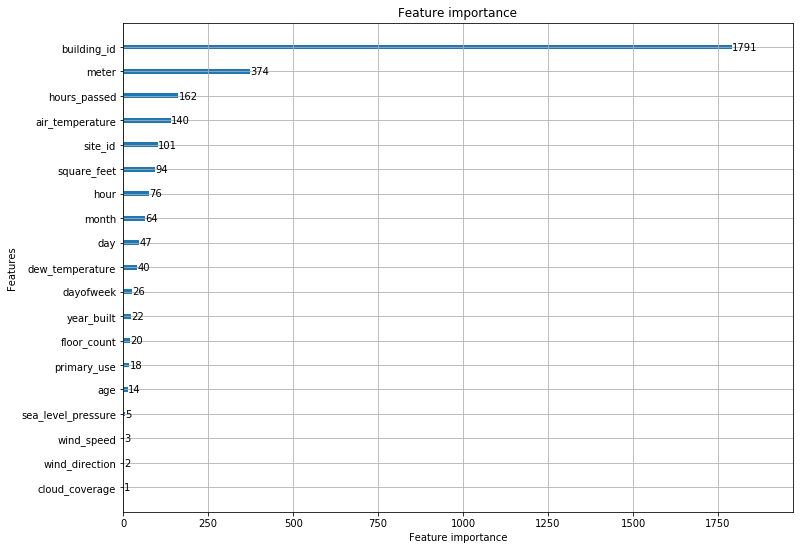

In [23]:
fig, ax = plt.subplots(figsize=(12, 9))
plot_importance(lgbmr_2nd_half, ax=ax)

In [24]:
del df_train, df_val, y_train, y_val, lgbmr
gc.collect()

0

In [25]:

STEP = 1000000
y_test_predict = []
for i in range(0, df_test.shape[0], STEP):
    batch_prediction = loaded_model.predict(df_test.loc[i:i+STEP-1,:])
    y_test_predict.append(list(batch_prediction))
y_test_1st_half = []
for predictions in y_test_predict:
    y_test_1st_half = y_test_1st_half + predictions
    
STEP = 1000000
y_test_predict = []
for i in range(0, df_test.shape[0], STEP):
    batch_prediction = loaded_model.predict(df_test.loc[i:i+STEP-1,:])
    y_test_predict.append(list(batch_prediction))
y_test_2nd_half = []
for predictions in y_test_predict:
    y_test_2nd_half = y_test_2nd_half + predictions

In [26]:
# sample['meter_reading'] = y_test
sample['meter_reading'] = (pd.Series(data=y_test_1st_half, name='pred_1st_half') + 
                           pd.Series(data=y_test_2nd_half, name='pred_2nd_half'))/2 

In [27]:
from math import e
# sample['meter_reading'] = e**sample['meter_reading'] - 1
sample['meter_reading'] = np.expm1(sample['meter_reading'])

## Submittion file

In [28]:
sample.to_csv("submission.csv", index=False, float_format='%.4f')